# Dados COVID19 em .ipynb  26/04/2020

        Tentando importar e utilizar os dados do Ministério da Saúde em https://covid.saude.org.br para avaliar a situação divulgada oficialmente pelo MS; 
        A url muda diariamente, há uma série de caracteres em primeira vista aleatórios que é atualizada também todo dia... como puxar o arquivo csv automaticamente?
        O site não disponibiliza dados de SRAG, apenas uma tabela repetida do COVID desatualizada.
        Nova tabela com dados do Brasil (população)
         Dados de SRAG da fiocruz em padrão brasileiro (109,0009) como transformar o arquivo em padrão americano/internacional (109.0009) automaticamente pela URL?

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado
        
        Mostrar dados de SRAG e comparar com o aumento dos números confirmados de COVID
        Dados em semana epidemiológica

## Estimativas (Regressão)
        
        Estimar próximos números (até 7 dias?) utilizando 2, 3 ou 4 (todos?) dias anteriores e regressão não linear
        Estimar curvas com ajuda dos dados de SRAG inconclusivos (qual a porcentagem de testes incompletos espera-se que serão confirmados)
        
## Modelo de Contágio

        Utilizar dados adquiridos para rodar um modelo epidemiológico que utiliza valores de reprodução base e evolução da COVID-19, causada pelo vírus SARS-COV-2
  

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

url_B = "https://raw.githubusercontent.com/Yannngn/COVID19-04-20/master/brasil.csv"
url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/3d784af876ac289233fb9a2d189f71c4_Download_COVID19_20200426.csv"

In [2]:
brasil = pd.read_csv(url_B, sep = ';')
df = pd.read_csv(url_C, sep = ";")

In [3]:
FMT = '%Y-%m-%d'

date = df['data']
regi = df['regiao']

df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)


In [4]:
df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos', 'estado']]
df_UF = df.loc[:, ['estado', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

In [5]:
df1 = df1.groupby("data").sum()

# total of days since 2020-01-30 - x
x = list(df1.index)

In [65]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return [a, b]

def exp_est (R, X) :
    np.random.seed(max(x))
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return a * np.exp(b * (max(x) + 1)) + norm.rvs(size = 1,scale = 0.05 * (max(x) + 1))

In [80]:
desc = ["total cases", "new cases", "total deaths", "new deaths"]
print("The errors of the exponential model parameters of: \n")

for i in range(4) :
    y = list(df1.iloc[:, i])
    exp_p = exp_param([y[-4], y[-3], y[-1]], [x[-4], x[-3], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] - 1, exp_p[1], 1])
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1],
                                                        exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))
    
    exponential_errors = [np.sqrt(exponential_fit[1][j][j]) for j in [0, 1, 2]]
   
    print(desc[i] + " numbers are: " + str(exponential_errors) + "\n")

The errors of the exponential model parameters of: 

total cases numbers are: [29549527.23339656, 0.0014713490334887886, 3683324.2353184004]

new cases numbers are: [29647029.878081262, 0.00564550143185401, 24637906.245934166]

total deaths numbers are: [46760.91051310341, 0.0017899558510270828, 685419.6248960244]

new deaths numbers are: [104741244.26413523, 1010.0014078680232, 466721014.45925546]



## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [72]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

a0 = 1.7

b0 = df1.index.size + 31
b1 = b0 + 14

pBrasil = brasil.at[brasil['UF'].eq('BR').idxmax(),'População']
c0 = 0.4 * pBrasil
c1 = 0.02 * pBrasil
c2 = 0.02 * c0
c3 = 0.02 * c2

list(df1)[0]

'casosAcumulados'

In [68]:
print("The errors of the logistic model parameters of: \n")

for i in range(4) :
    y = list(df1.iloc[:, i])

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c0])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
    
    logistic_errors = [np.sqrt(logistic_fit[1][j][j]) for j in [0, 1, 2]]
   
    print(desc[i] + " numbers are: " + str(logistic_errors) + "\n")

The errors of the logistic model parameters of: 

total cases numbers are: [0.19643117596899176, 0.7838791957251554, 4875.948572186694]

new cases numbers are: [1.8745847596010865, 9.71577324953647, 4036.8670569308015]

total deaths numbers are: [0.20478796817648426, 0.7850528821072706, 378.8170501871789]

new deaths numbers are: [1.7505456735312865, 5.529884177819141, 126.4653695570321]




# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

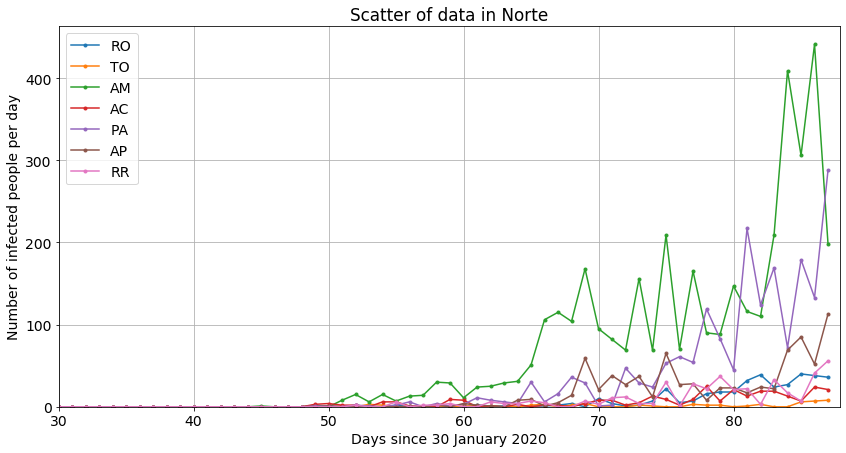

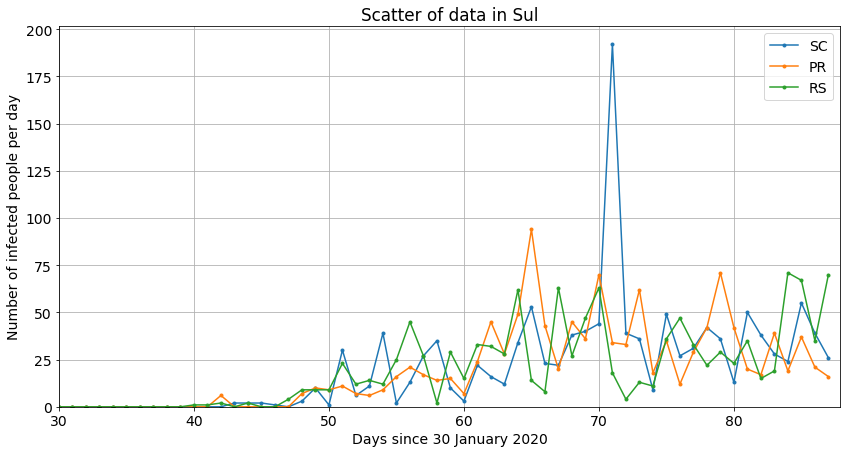

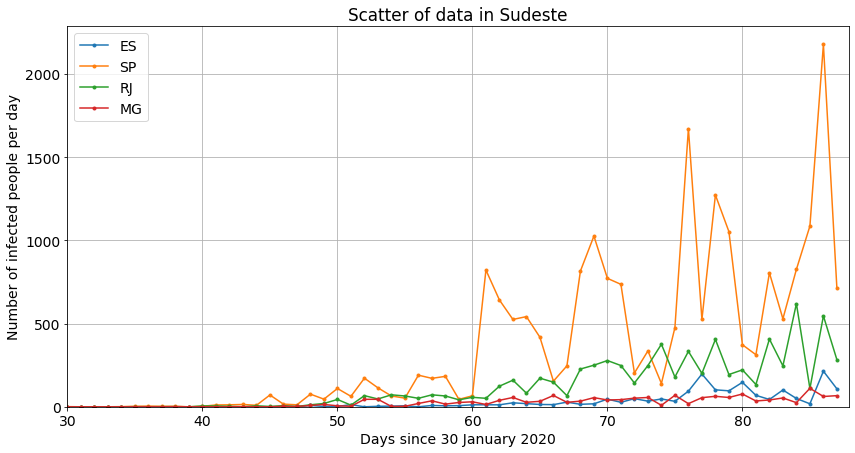

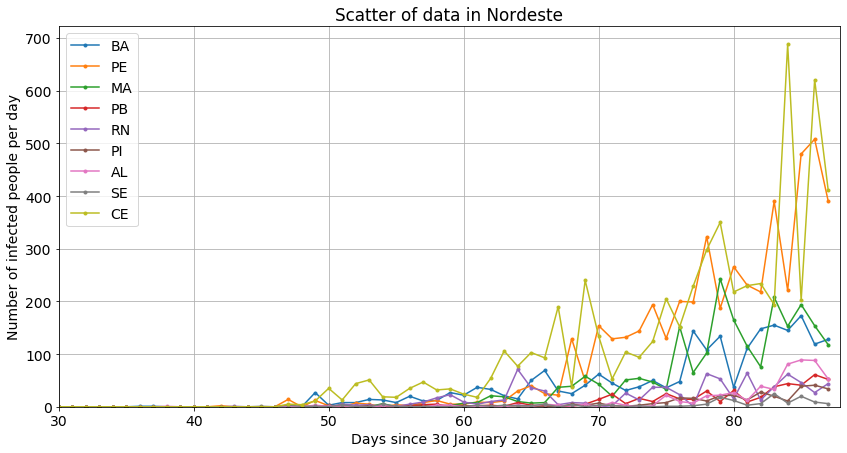

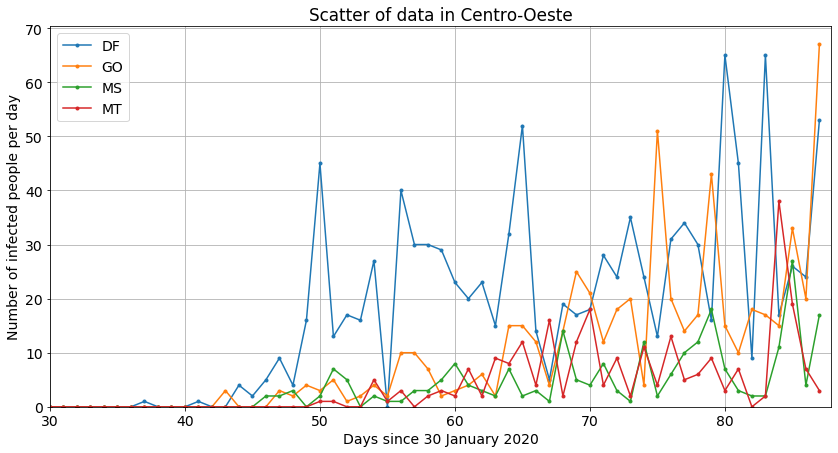

In [69]:
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

dfs = dfs.sort_values("data")
y = list(dfs.iloc[:, 3])

# Real data
# Brazilian areas separated

regioes = dfs["regiao"].unique()
estados = list(dfs["estado"].unique())

for r in regioes : 
    plt.grid(True)
    for e in estados :
        yx = max(dfs[dfs['regiao'] == r].iloc[:, 3])
        uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Regiao"]
        if uf == r :
            xs = list(dfs[dfs['estado'] == e].iloc[:, 1])
            ys = list(dfs[dfs['estado'] == e].iloc[:, 3])
            plt.plot(xs, ys, marker = '.', label = e)
    plt.title("Scatter of data in " + r)
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Number of infected people per day")
    plt.xlim(30, max(xs) * 1.01)
    plt.ylim(0, yx * 1.05)
    plt.show()


Expected final values: end of spread in 94 days, with 103227.906 confirmed numbers in Brazil


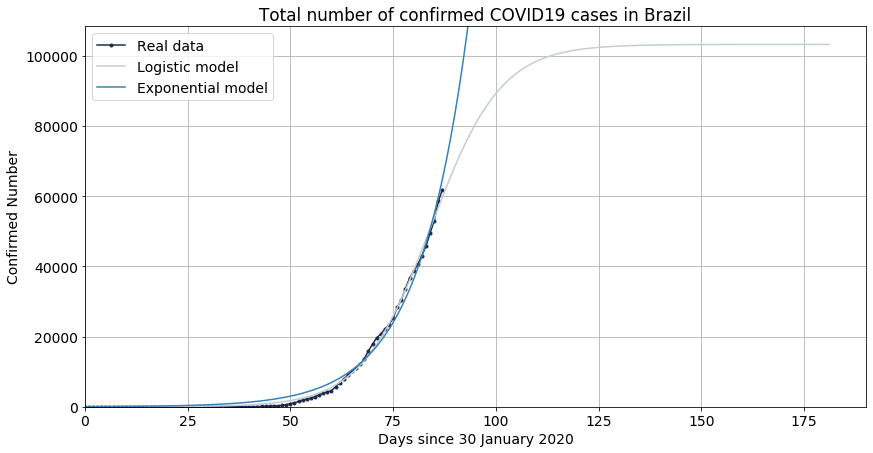

Next estimated total number of confirmed cases is 70496.064


C:\Users\calad\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\calad\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


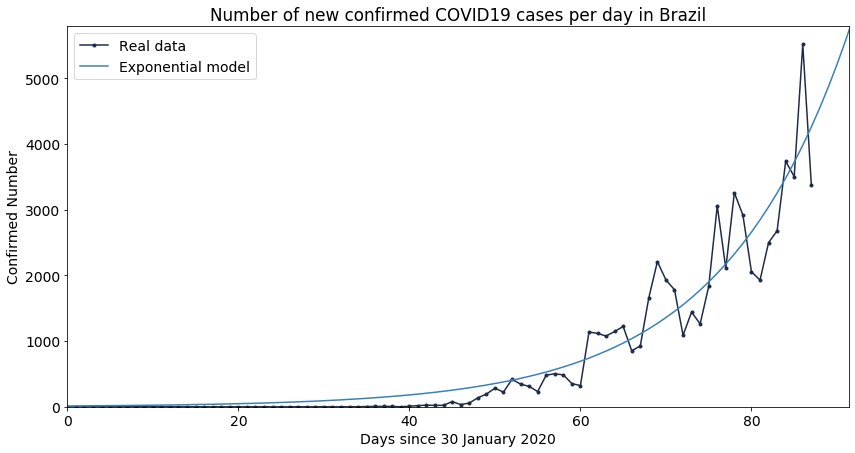

Next estimated total number of confirmed cases is 4552.568
Expected final values: end of spread in 64 days, with 6901.513 confirmed numbers in Brazil


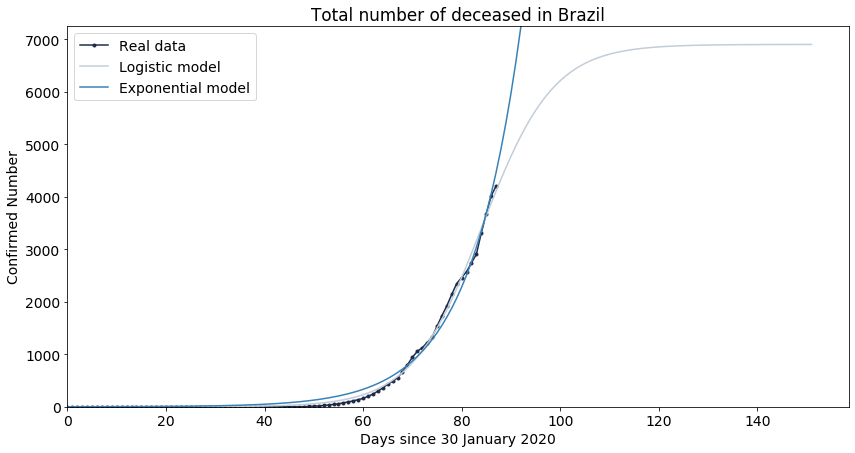

Next estimated total number of confirmed cases is 4915.932


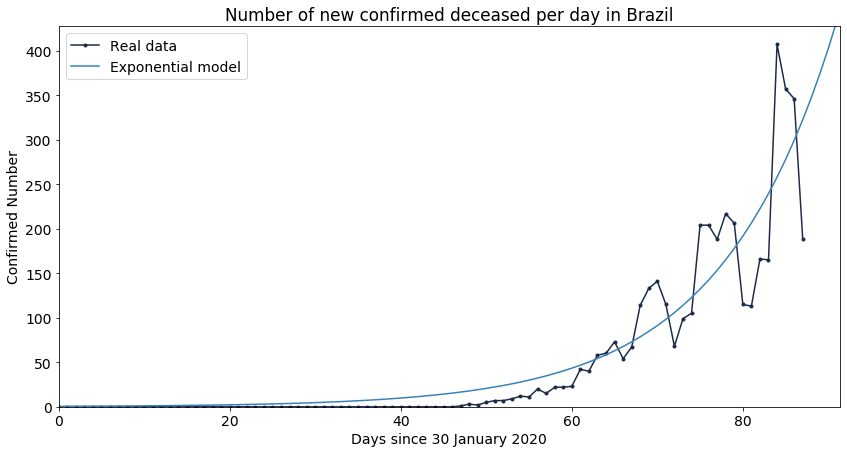

Next estimated total number of confirmed cases is 347.1


In [77]:
ttl = ["Total number of confirmed COVID19 cases in Brazil",
         "Number of new confirmed COVID19 cases per day in Brazil",
         "Total number of deceased in Brazil",
         "Number of new confirmed deceased per day in Brazil"]

for f in range(4) :
   
    plt.grid(True)
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 7]
    
    y = list(df1.iloc[:, f])
    
    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c0])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]),
                              logistic_fit[0][1]))
    
    exp_p = exp_param([y[-6], y[-3], y[-1]], [x[-6], x[-3], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] - 1, exp_p[1], 1])
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                              exponential_fit[0][2]) - int(exponential_fit[0][2]),
                                 exponential_fit[0][1]))
    
    pred_x = list(range(max(x), logistic_sol))

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")
    
    # Predicted logistic curve for the total data
    if (f == 0 or f == 2) :
   
        plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                              for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
        print("Expected final values: end of spread in " + str(max(pred_x) - max(x))
              + " days, with " + str(round(logistic_fit[0][2], 3)) + " confirmed numbers in Brazil")
        
    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")

    plt.title(ttl[f])
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Confirmed Number")
    
    if (f == 0 or f == 2) :
        plt.xlim(0, max(pred_x) * 1.05)
        plt.ylim(0, logistic_fit[0][2] * 1.05)
    else :
        plt.ylim(0, max(y) * 1.05)
        plt.xlim(0, max(x) * 1.05)
    plt.show()
    print("Next estimated total number of confirmed cases is " + 
          str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3)))


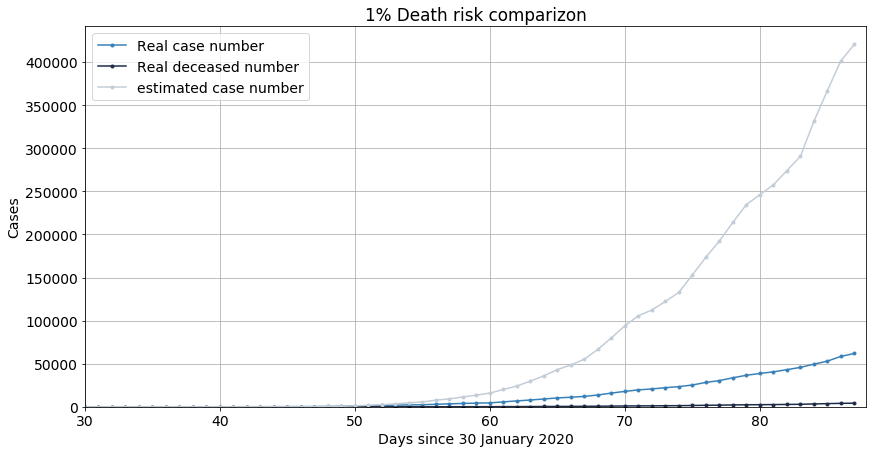

Expected actual value is: 420500 in day 87


In [25]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data

y = list(df1.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df1.iloc[:, 2])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df1.iloc[:, 2].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.xlim(30, max(x) * 1.01)
plt.ylim(0, max(y) * 1.05)
plt.show()
print("Expected actual value is: " + str(max(y)) + " in day " + str(max(x)))

## Casos Totais por estado
    
    Casos confirmados x tempo
    
    Dados reais, estimativa exponencial e em estados com mais de 1000 casos estimativa logistica
    
    Os dados são subnotificados e possuem baixa confiabilidade

Next number of confirmed is 445.849 in RO


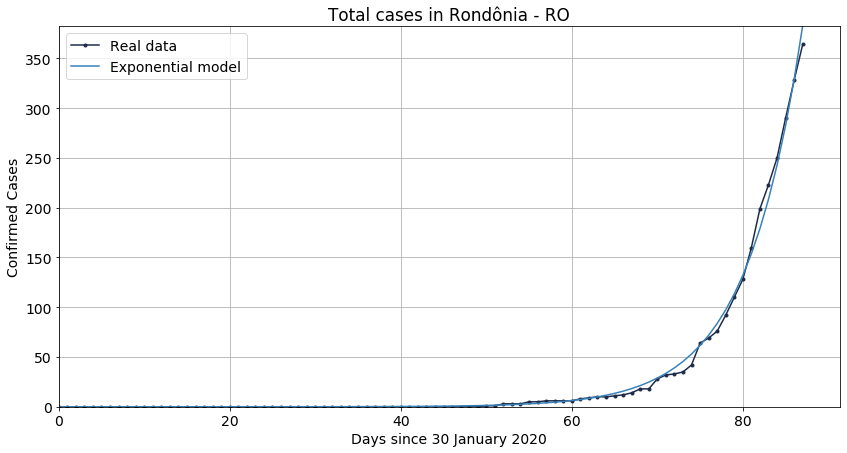

Next number of confirmed is 261.589 in MS


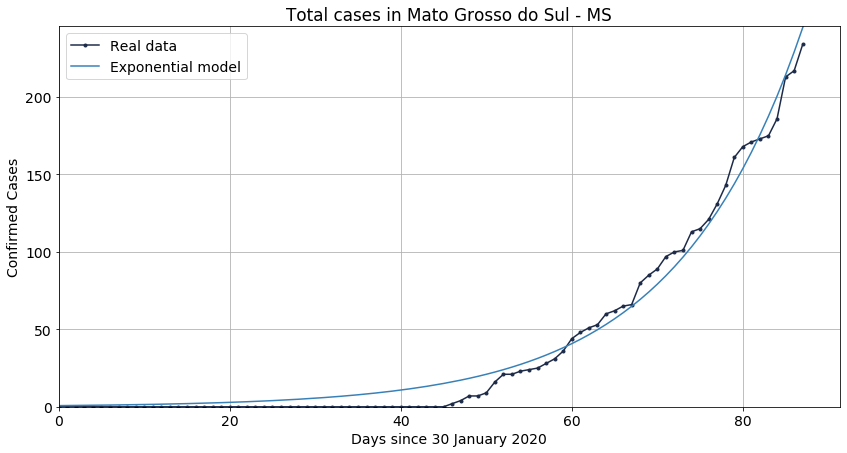

Expected final values: end of spread in 186 days with 4768.0 cases in PA
Next number of confirmed is 2189.339 in PA


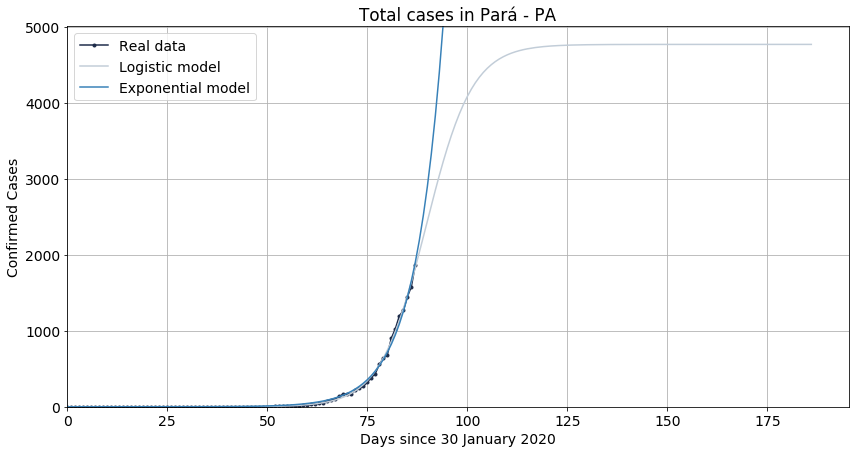

Next number of confirmed is 675.838 in AL


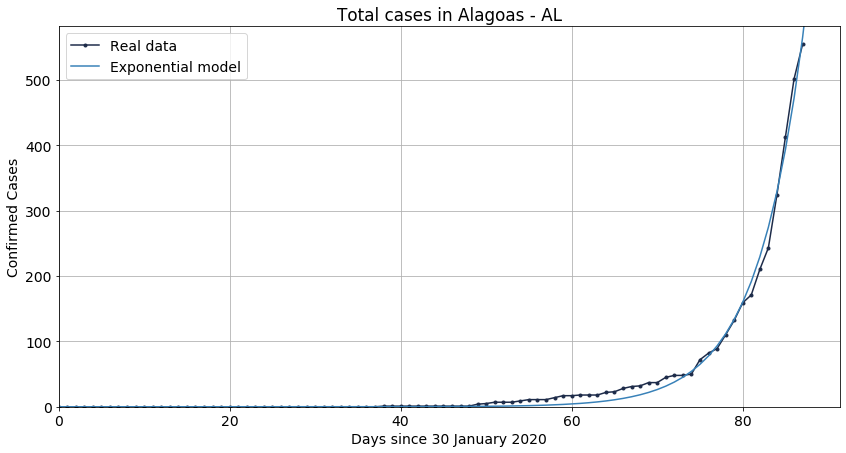

Next number of confirmed is 174.252 in SE


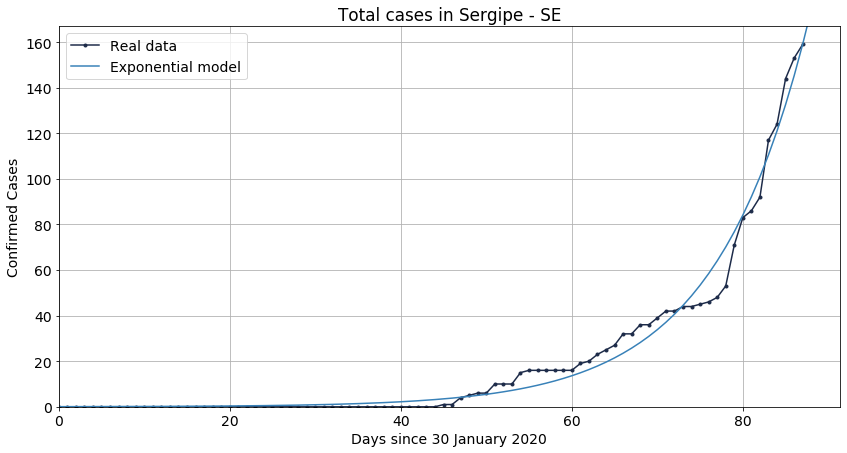

Expected final values: end of spread in 202 days with 17037.088 cases in CE
Next number of confirmed is 6529.52 in CE


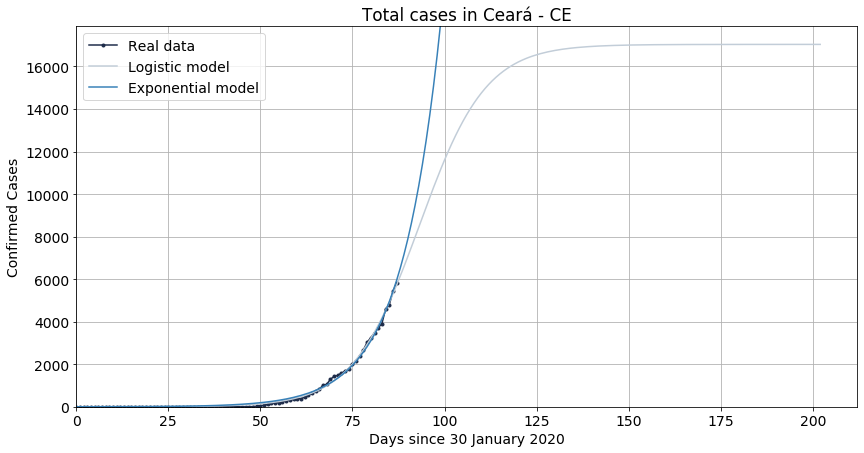

Expected final values: end of spread in 153 days with 9618.584 cases in RJ
Next number of confirmed is 8369.897 in RJ


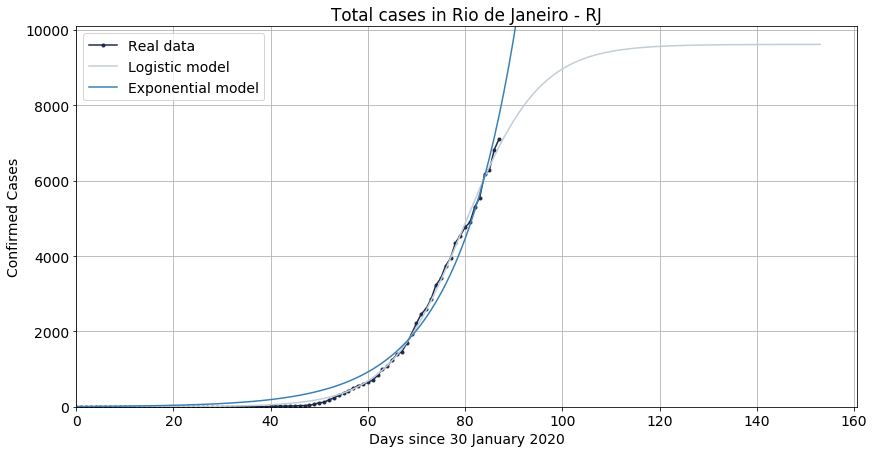

Next number of confirmed is 455.067 in RR


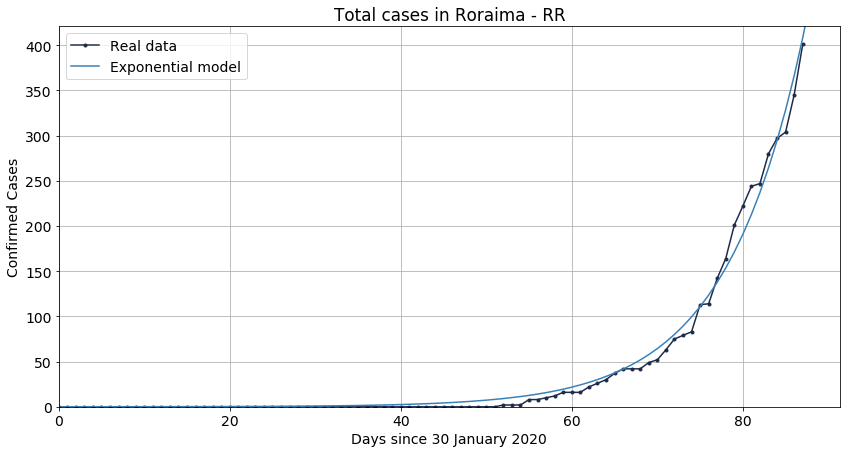

Next number of confirmed is 299.877 in MT


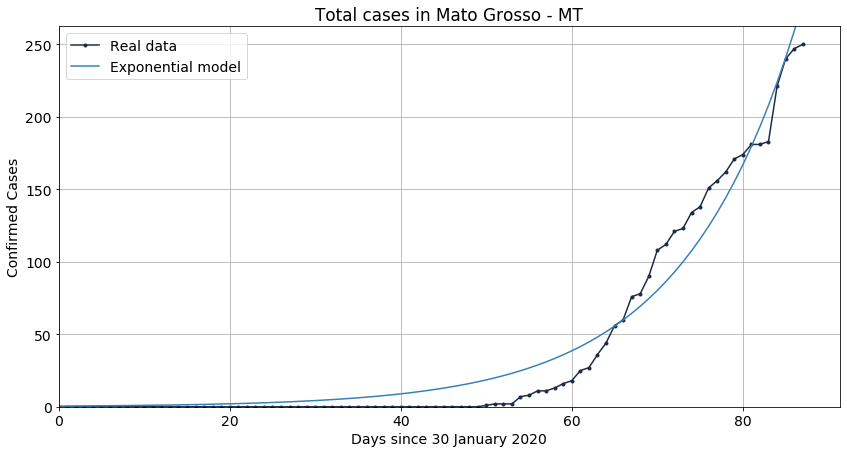

Expected final values: end of spread in 136 days with 1191.265 cases in RS
Next number of confirmed is 1346.328 in RS


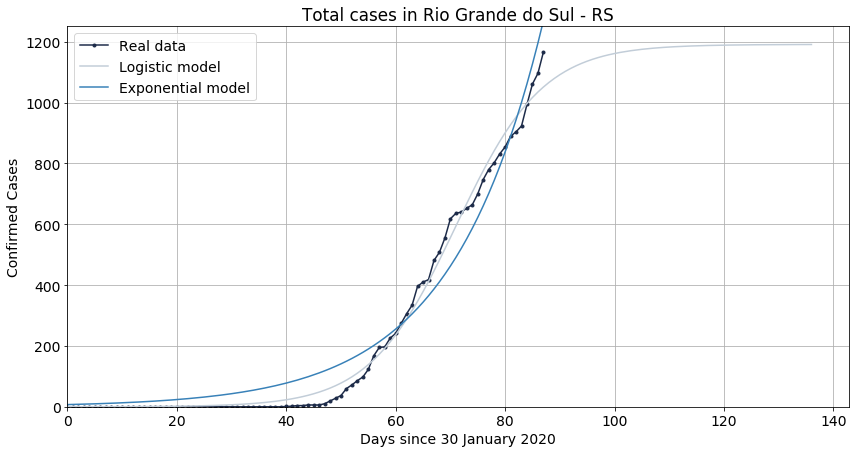

Next number of confirmed is 885.667 in AP


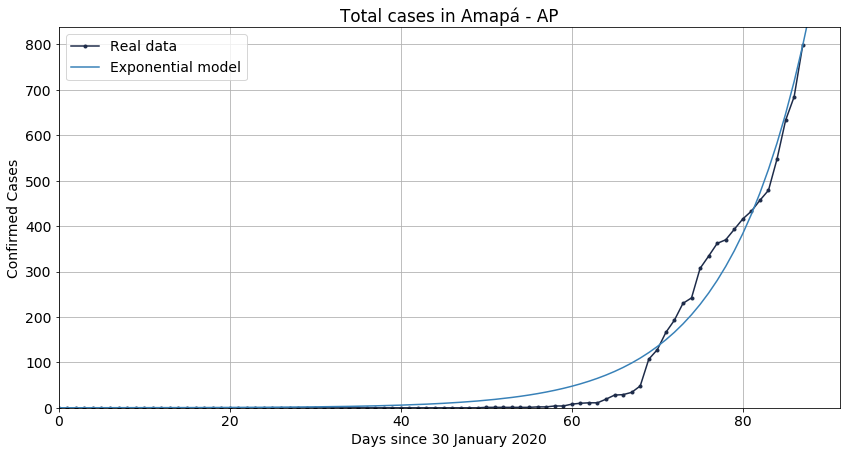

Expected final values: end of spread in 139 days with 1841.792 cases in MG
Next number of confirmed is 1815.465 in MG


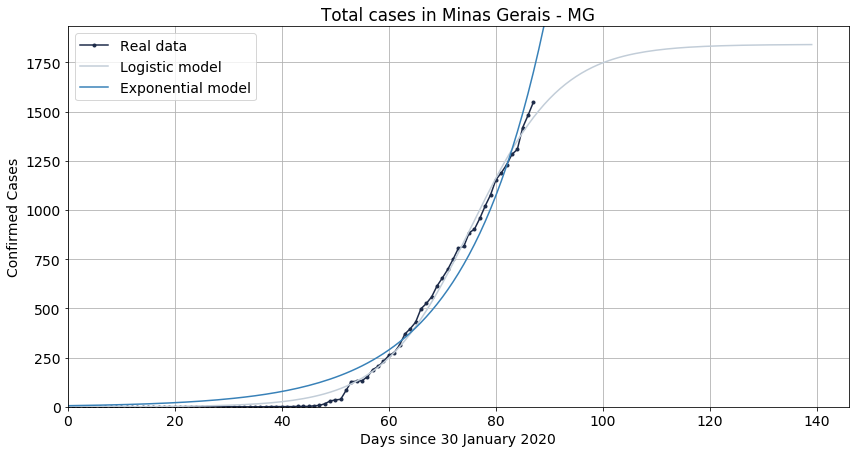

Next number of confirmed is 963.111 in RN


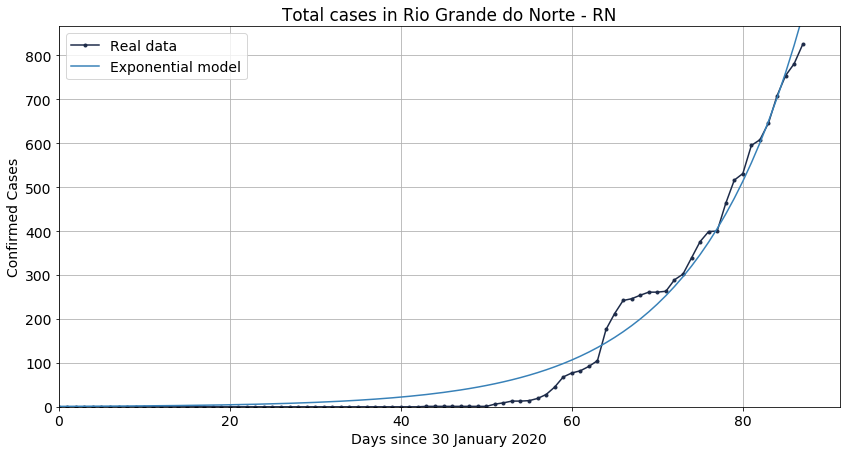

Next number of confirmed is 381.781 in PI


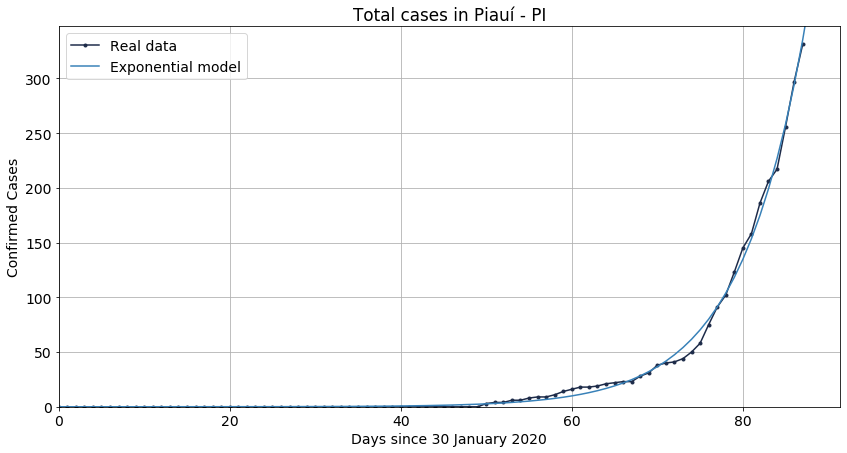

Expected final values: end of spread in 164 days with 26472.426 cases in SP
Next number of confirmed is 23933.19 in SP


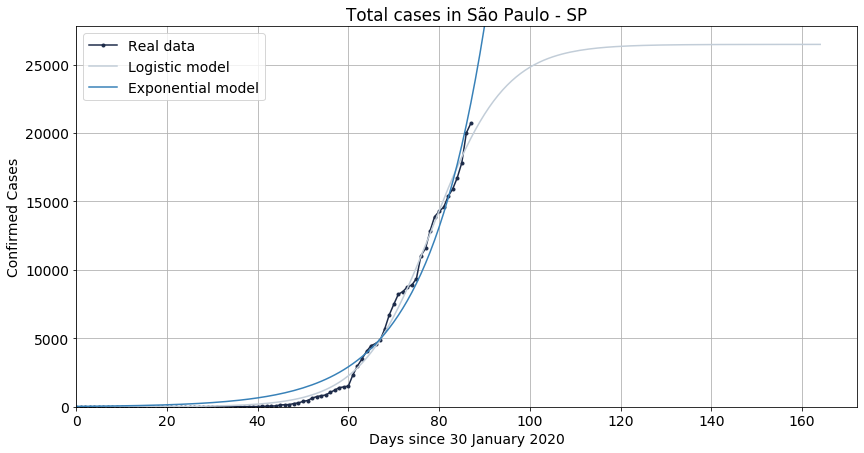

Next number of confirmed is 562.787 in PB


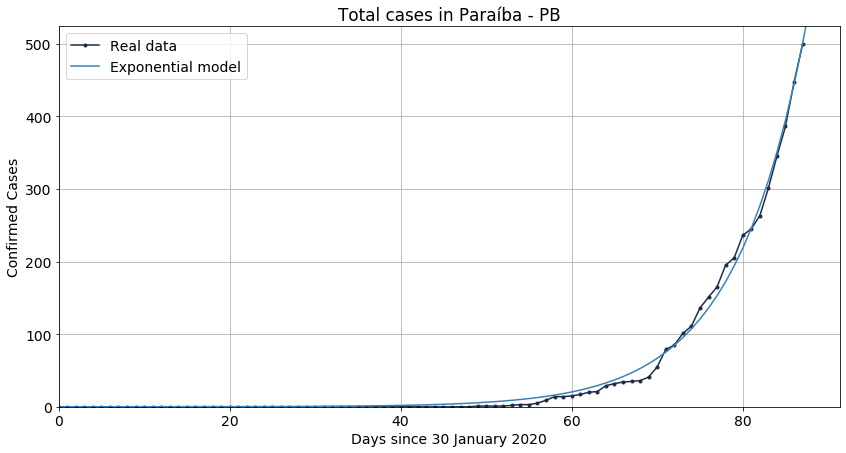

Next number of confirmed is 647.985 in GO


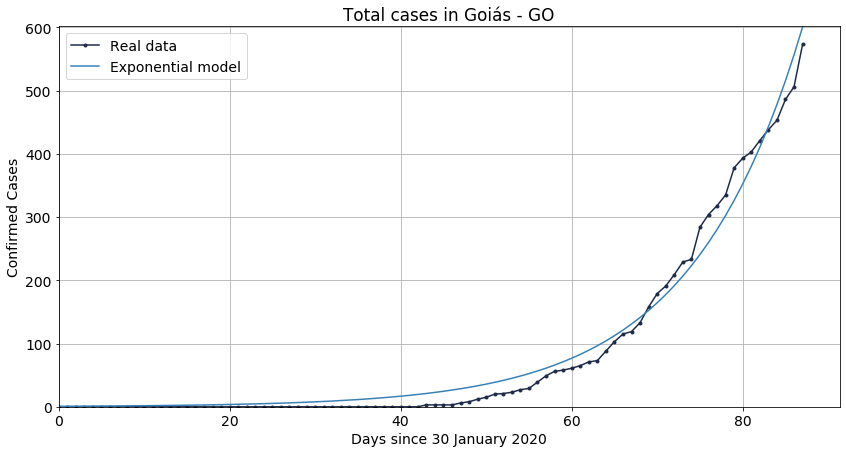

Expected final values: end of spread in 161 days with 1198.066 cases in DF
Next number of confirmed is 1252.089 in DF


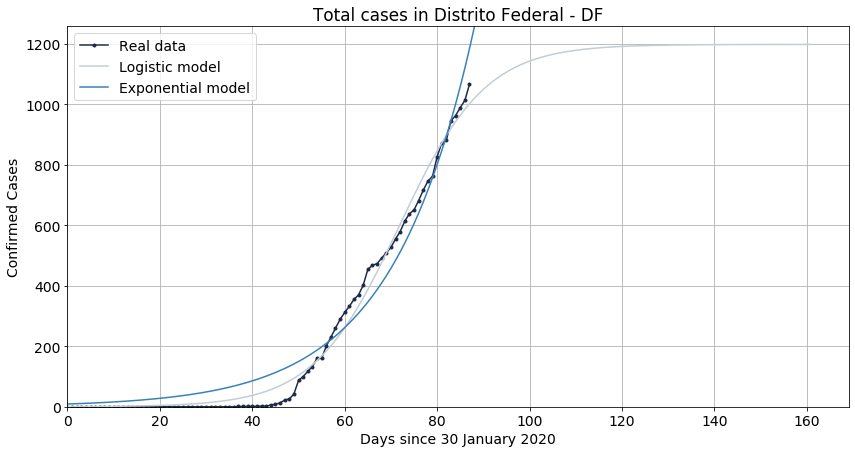

Next number of confirmed is 312.265 in AC


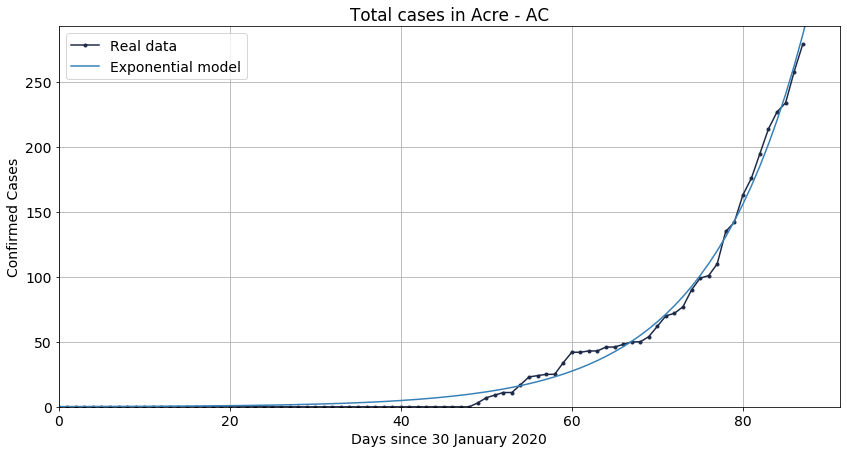

Expected final values: end of spread in 116 days with 1202.58 cases in PR
Next number of confirmed is 1476.444 in PR


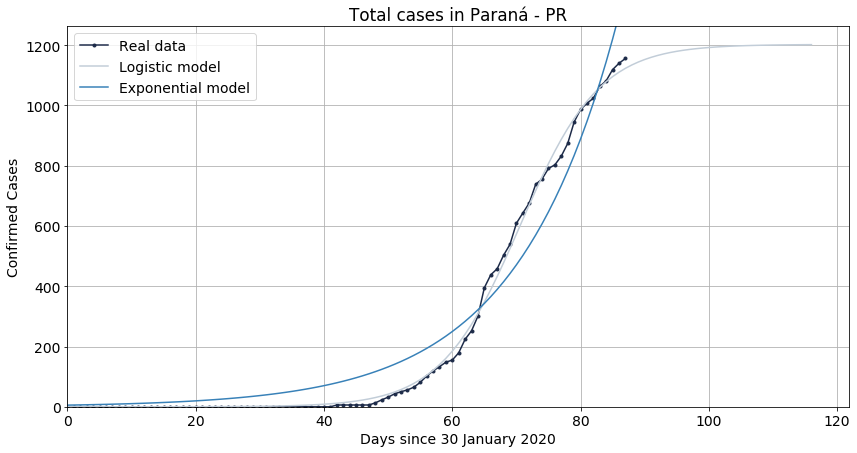

Expected final values: end of spread in 126 days with 3383.699 cases in MA
Next number of confirmed is 2766.736 in MA


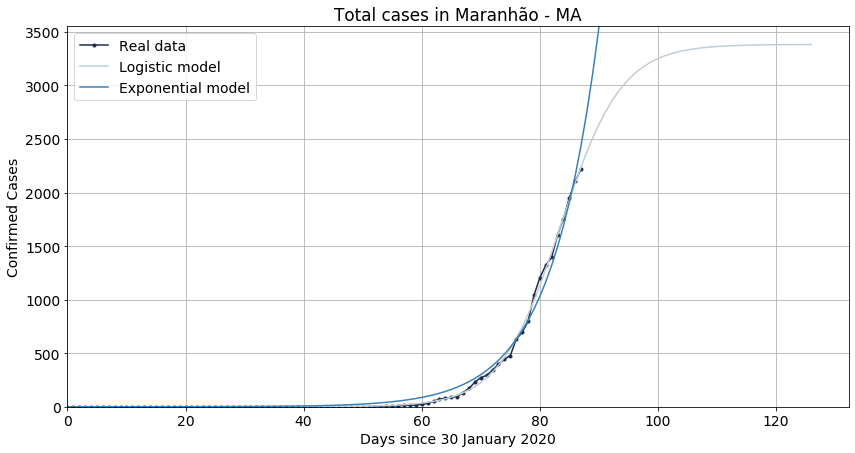

Expected final values: end of spread in 163 days with 7957.592 cases in AM
Next number of confirmed is 4317.677 in AM


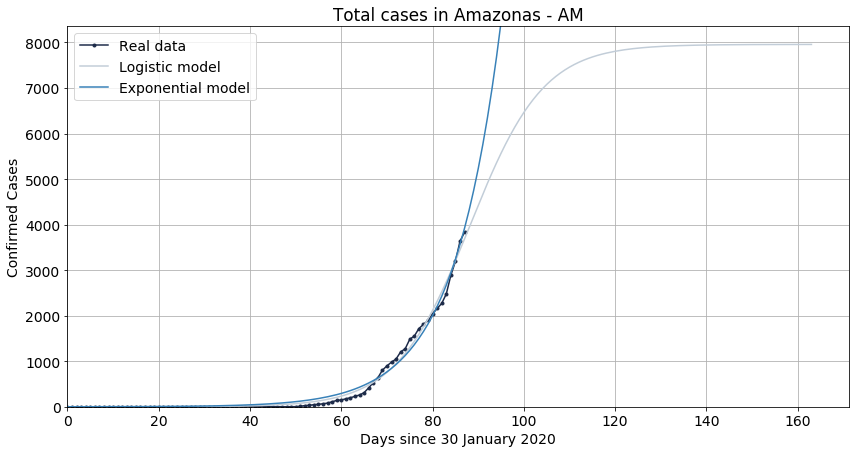

Expected final values: end of spread in 137 days with 8293.839 cases in PE
Next number of confirmed is 5798.755 in PE


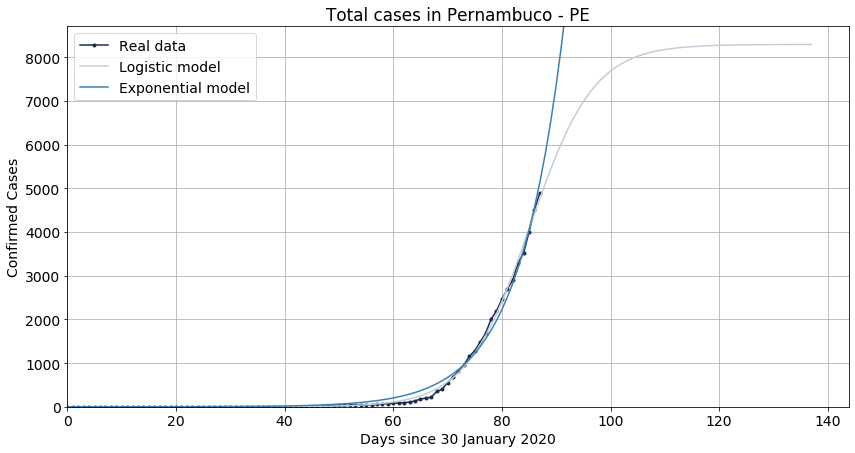

Expected final values: end of spread in 183 days with 7189.584 cases in BA
Next number of confirmed is 2523.237 in BA


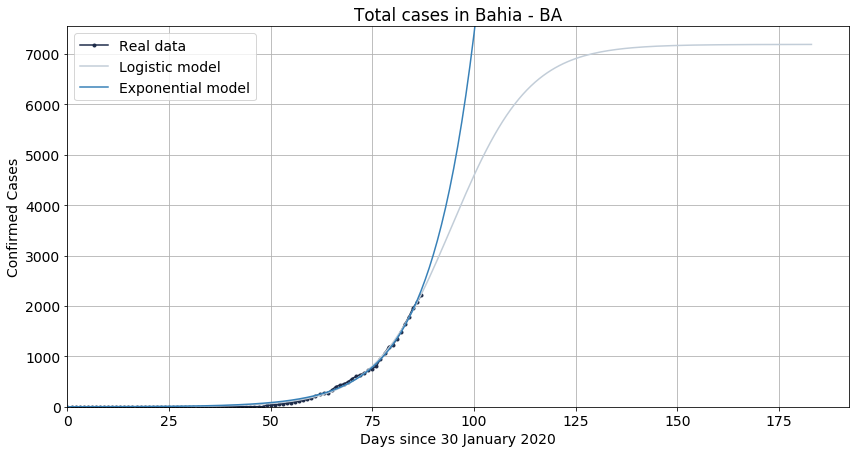

Expected final values: end of spread in 142 days with 2273.04 cases in ES
Next number of confirmed is 2045.635 in ES


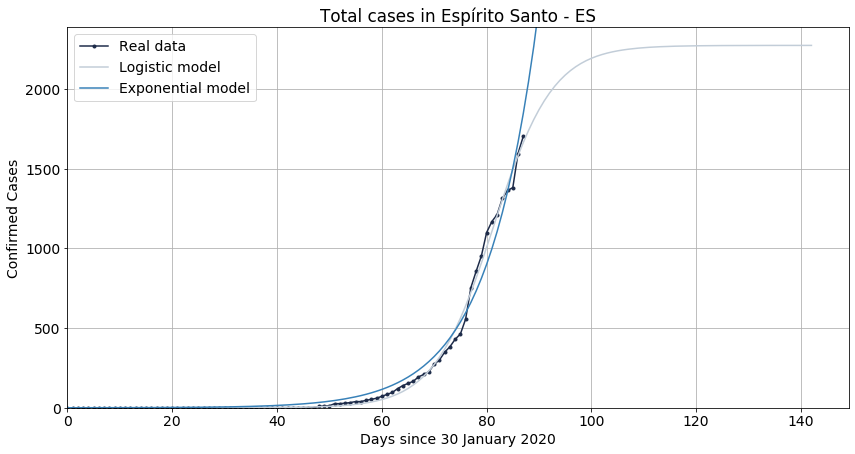

Next number of confirmed is 56.762 in TO


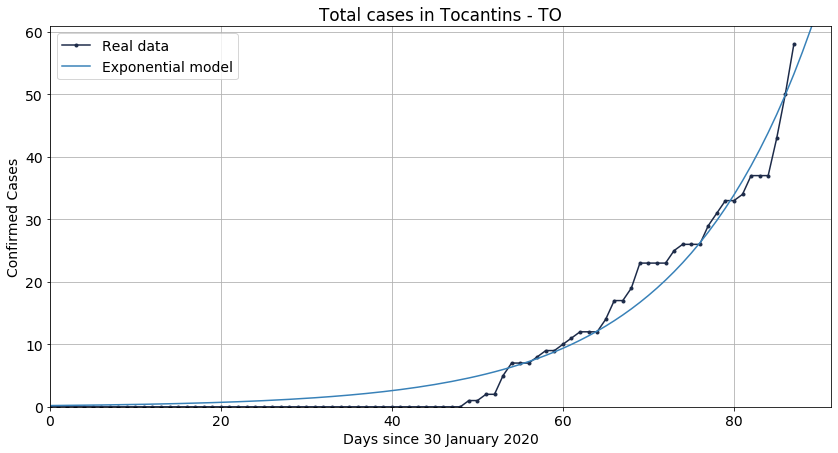

Expected final values: end of spread in 119 days with 1322.836 cases in SC
Next number of confirmed is 1540.124 in SC


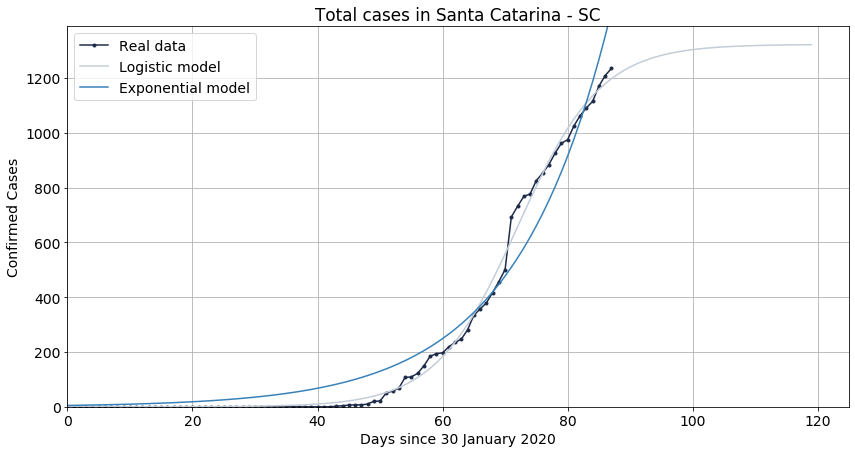

In [26]:
plt.grid(True)
plt.rcParams['figure.figsize'] = [14, 7]

estados = dfs["estado"].unique()

for e in estados :
    df_e = df_UF.loc[df_UF.iloc[:,0] == e, :].iloc[:, [1, 2]]
    pop = brasil.at[brasil['UF'].eq(e).idxmax(),'População']
    uf = brasil.at[brasil['UF'].eq(e).idxmax(), "Unidade da Federação"]
    x = list(df_e.iloc[:, 0])
    y = list(df_e.iloc[:, 1])

    plt.grid(True)
    plt.rcParams['figure.figsize'] = [14, 7]

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

    exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df_e.index.size))
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                                  exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

    if max(y) > 1000 :
        logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 0.4 * pop])
        logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                            logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

        pred_x = list(range(max(x), logistic_sol))

        # Predicted logistic curve
        plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                              for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
        
        plt.xlim(0, max(pred_x) * 1.05)
        plt.ylim(0, logistic_fit[0][2] * 1.05)
        print("Expected final values: end of spread in " + str(max(pred_x)) + " days with " + str(round(logistic_fit[0][2], 3)) + " cases in " + e)
        
    else :
        plt.xlim(0, max(x) * 1.05)
        plt.ylim(0, max(y) * 1.05)

    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")
    
    print("Next number of confirmed is "+ str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3)) + " in " + e)
    
    plt.title("Total cases in " + uf + ' - ' + e)
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Confirmed Cases")
    plt.show()        

## New Features

In [ ]:
#debugging

est = 'SP'

df_PE = df_UF.loc[df_UF.iloc[:,0] == est, :].iloc[:, [1, 2]]
pop = brasil.at[brasil['UF'].eq(est).idxmax(),'População']
y = list(df_PE.iloc[:, 1])

plt.grid(True)

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 0.4 * pop])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

pred_x = list(range(max(x), logistic_sol))

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Logistic errors
# plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0] + np.sqrt(logistic_fit[1][0][0]), 
#                                      logistic_fit[0][1] + np.sqrt(logistic_fit[1][1][1]),
#                                      logistic_fit[0][2] + np.sqrt(logistic_fit[1][2][2]))
#                       for i in x + pred_x], label = "Logistic model max", color = "#ee5907")

# plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0] - np.sqrt(logistic_fit[1][0][0]), 
#                                      logistic_fit[0][1] - np.sqrt(logistic_fit[1][1][1]),
#                                      logistic_fit[0][2] - np.sqrt(logistic_fit[1][2][2]))
#                       for i in x + pred_x], label = "Logistic model min", color = "#66983f")


# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")
exponential_errors = [np.sqrt(exponential_fit[1][i][i]) for i in [0, 1, 2]]

# Exponential errors

# plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0] + np.sqrt(exponential_fit[1][0][0]), 
#                                      exponential_fit[0][1] + np.sqrt(exponential_fit[1][1][1]),
#                                      exponential_fit[0][2] + np.sqrt(exponential_fit[1][2][2]))
#                       for i in x + pred_x], label = "Logistic model max", color = "#ee5907")

# plt.plot(x + pred_x, [exponential_model(i, logistic_fit[0][0] - np.sqrt(exponential_fit[1][0][0]), 
#                                      exponential_fit[0][1] - np.sqrt(exponential_fit[1][1][1]),
#                                      exponential_fit[0][2] - np.sqrt(exponential_fit[1][2][2]))
#                       for i in x + pred_x], label = "Exponential model min", color = "#66983f")

plt.title("Total cases in " + brasil.at[brasil['UF'].eq(est).idxmax(), "Unidade da Federação"])
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, (logistic_fit[0][2] + np.sqrt(logistic_fit[1][2][2])) * 1.05)
plt.show()
print(exponential_errors)